## Preprocessing and Exploring the Data

In [1]:
import numpy as np
import torch as nn
import pandas as pd
from sklearn.feature_extraction import text
from datasets import load_dataset, DatasetDict

# This loads in the dataset 'sms spam' and splits it into train, test and validation sets
initial_dataset = load_dataset('sms_spam')
train_test_dataset = initial_dataset["train"].train_test_split(test_size=0.3)
test_valid_dataset = train_test_dataset['test'].train_test_split(test_size=0.6)

# This is the dataset that we will be using, it is a dictionary with keys 'train', 'test' and 'valid'
# Each key has a dataset with the columns 'text' and 'label'
# The 'text' column contains the text of the message and the 'label' column contains the label of the message
# The label is 0 if the message is not spam and 1 if the message is spam 
dataset = DatasetDict({
    'train': train_test_dataset['train'],
    'test': test_valid_dataset['test'],
    'valid': test_valid_dataset['train']})
print(dataset)
print(dataset['train'][0])


/Users/kevinzhuo/Spam_Detection/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['sms', 'label'],
        num_rows: 3901
    })
    test: Dataset({
        features: ['sms', 'label'],
        num_rows: 1004
    })
    valid: Dataset({
        features: ['sms', 'label'],
        num_rows: 669
    })
})
{'sms': 'Okey dokey, i‘ll be over in a bit just sorting some stuff out.\n', 'label': 0}


Number of spam messages in initial dataset: 747
Number of not spam messages in initial dataset: 4827


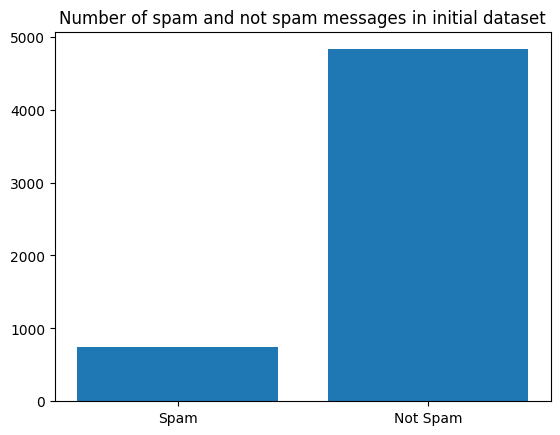

Number of spam messages in training dataset: 522
Number of not spam messages in training dataset: 3379


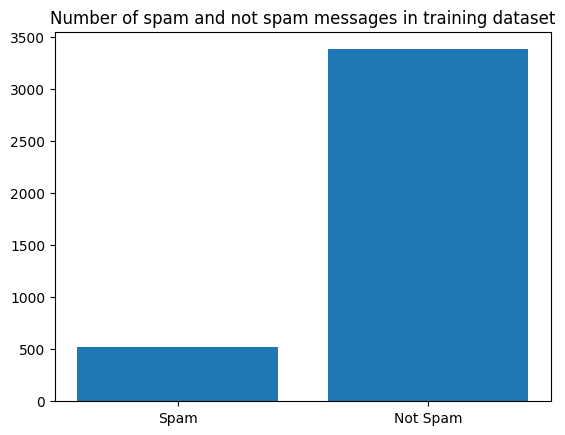

In [2]:
import matplotlib.pyplot as plt

# This is the distribution of spam and not spam messages in the initial dataset, without any of the splits
num_spam = sum(initial_dataset['train']['label'])
num_not_spam = len(initial_dataset['train']['label']) - num_spam
print(f"Number of spam messages in initial dataset: {num_spam}")
print(f"Number of not spam messages in initial dataset: {num_not_spam}")  

# Plotting the distribution of spam and not spam messages in the initial dataset
overall_plt = plt.bar(['Spam', 'Not Spam'], [num_spam, num_not_spam])
plt.title('Number of spam and not spam messages in initial dataset')
plt.show()

# This is the distribution of spam and not spam messages in the training dataset
num_train_spam = sum(dataset['train']['label'])
num_train_not_spam = len(dataset['train']['label']) - num_train_spam
print(f"Number of spam messages in training dataset: {num_train_spam}")
print(f"Number of not spam messages in training dataset: {num_train_not_spam}")

# Plotting the distribution of spam and not spam messages in the training dataset
overall_plt1 = plt.bar(['Spam', 'Not Spam'], [num_train_spam, num_train_not_spam])
plt.title('Number of spam and not spam messages in training dataset')
plt.show()

We can see that the label distribution is relatively unbalanced, with 15.5% of the initial dataset being 'spam' and 84.5% of the initial dataset being labeled as 'not spam'. 

Similarly, the label distribution of the training dataset exhibits the same properties, with 15.4% of the training dataset being 'spam' and 84.6% of the training dataset labeled as 'not spam'.

Due to this imbalance of the label distributions, we will incorporate other evaluation metrics such as F1 score and balanced accuracy to get a more comprehensive and reliable assessment of the model's performance.

[('to', 2145), ('you', 1626), ('I', 1469), ('a', 1337), ('the', 1207), ('and', 858), ('in', 800), ('is', 788), ('i', 748), ('u', 698)]


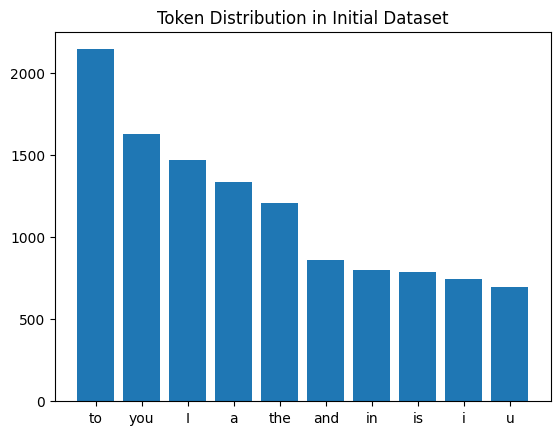

[('to', 1506), ('you', 1165), ('I', 1051), ('a', 918), ('the', 838), ('and', 633), ('in', 559), ('i', 543), ('is', 538), ('u', 495)]


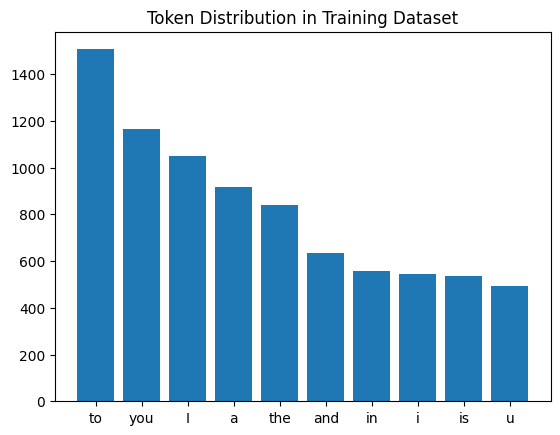

In [20]:
from collections import Counter

initial_counter = Counter()
for message in initial_dataset['train']['sms']:
    initial_counter.update(message.split())
print(initial_counter.most_common(10))
initial_plt = plt.bar([initial_counter.most_common(10)[i][0] for i in range(10)], [initial_counter.most_common(10)[i][1] for i in range(10)])
plt.title('Token Distribution in Initial Dataset')
plt.show()


training_counter = Counter()
for message in dataset['train']['sms']:
    training_counter.update(message.split())
print(training_counter.most_common(10))
train_plt = plt.bar([training_counter.most_common(10)[i][0] for i in range(10)], [training_counter.most_common(10)[i][1] for i in range(10)])
plt.title('Token Distribution in Training Dataset')
plt.show()


## Model Training Pipeline

In [3]:
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score, confusion_matrix

# Creates a function that is used to compute different metrics given the predictions and labels
# The function calculates the different predictions and then computes the accuracy, f1 score and balanced accuracy
# Returns: A dictionary with the accuracy, f1 score and balanced accuracy
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy_val = accuracy_score(labels, predictions)
    f1_score_val = f1_score(labels, predictions)
    balanced_accuracy_val = balanced_accuracy_score(labels, predictions)
    confusion_matrix_val = confusion_matrix(labels, predictions)
    return {
        'accuracy': accuracy_val,
        'f1': f1_score_val,
        'balanced_accuracy': balanced_accuracy_val,
        'confusion_matrix': confusion_matrix_val
    }

# Defines the training arguments that will be used for a model during the training steps and the specific arguments
training_args = TrainingArguments(
    output_dir='./results',          
    num_train_epochs=2,              
    per_device_train_batch_size=32,   
    per_device_eval_batch_size=16,   
    warmup_steps=500,                
    weight_decay=0.01,               
    logging_dir='./logs',            
    evaluation_strategy="epoch",    
)

# Define the trainer that will be used to train the model
def create_trainer(model, tokenized_dataset, tokenizer):
    trainer = Trainer(
        model=model,                   
        args=training_args,                 
        train_dataset=tokenized_dataset['train'],      
        eval_dataset=tokenized_dataset['valid'],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics           
    )
    return trainer

## Distilbert Model 

In [4]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# This loads in the DistilBERT tokenizer
distilbert_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

# This function tokenizes the text data with a given tokenizer
def distilbert_preprocess(examples):
    return distilbert_tokenizer(examples["sms"], truncation=True, padding=True)

# This tokenizes the dataset using the preprocess_function and the DistilBERT tokenizer
tokenized_dataset = dataset.map(distilbert_preprocess, batched=True)

print(tokenized_dataset)

Map: 100%|██████████| 669/669 [00:00<00:00, 30897.86 examples/s]

DatasetDict({
    train: Dataset({
        features: ['sms', 'label', 'input_ids', 'attention_mask'],
        num_rows: 3901
    })
    test: Dataset({
        features: ['sms', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1004
    })
    valid: Dataset({
        features: ['sms', 'label', 'input_ids', 'attention_mask'],
        num_rows: 669
    })
})


In [5]:
distilbert_model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased')

# This creates a trainer using the DistilBERT model, the training arguments, the tokenized dataset, the DistilBERT tokenizer and the compute_metrics function
trainer = create_trainer(distilbert_model, tokenized_dataset, distilbert_tokenizer)

# This trains the model using the trainer
trainer.train()

# This evaluates the model using the trainer
trainer.evaluate()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/kevinzhuo/Spam_Detection/venv/lib/python3.11/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
                                                 
 50%|█████     | 122/244 [01:31<01:26,  1.41it/s]

{'eval_loss': 0.03534691035747528, 'eval_accuracy': 0.992526158445441, 'eval_f1': 0.9751243781094527, 'eval_balanced_accuracy': 0.9795103226475775, 'eval_confusion_matrix': array([[566,   1],
       [  4,  98]]), 'eval_runtime': 3.0929, 'eval_samples_per_second': 216.299, 'eval_steps_per_second': 13.579, 'epoch': 1.0}


                                                 
100%|██████████| 244/244 [03:03<00:00,  1.33it/s]


{'eval_loss': 0.02811240591108799, 'eval_accuracy': 0.9910313901345291, 'eval_f1': 0.9696969696969697, 'eval_balanced_accuracy': 0.9705882352941176, 'eval_confusion_matrix': array([[567,   0],
       [  6,  96]]), 'eval_runtime': 2.842, 'eval_samples_per_second': 235.401, 'eval_steps_per_second': 14.779, 'epoch': 2.0}
{'train_runtime': 183.5505, 'train_samples_per_second': 42.506, 'train_steps_per_second': 1.329, 'train_loss': 0.19617494989614018, 'epoch': 2.0}


100%|██████████| 42/42 [00:02<00:00, 15.33it/s]


{'eval_loss': 0.02811240591108799,
 'eval_accuracy': 0.9910313901345291,
 'eval_f1': 0.9696969696969697,
 'eval_balanced_accuracy': 0.9705882352941176,
 'eval_confusion_matrix': array([[567,   0],
        [  6,  96]]),
 'eval_runtime': 2.8076,
 'eval_samples_per_second': 238.284,
 'eval_steps_per_second': 14.96,
 'epoch': 2.0}

100%|██████████| 63/63 [00:07<00:00,  7.93it/s]


DistilBERT test accuracy = 0.9930278884462151
DistilBERT test f1 score = 0.9707112970711297
DistilBERT test balanced accuracy = 0.9715447154471545


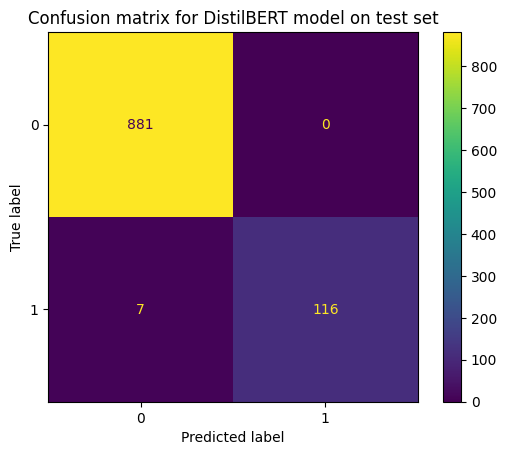

In [6]:
from sklearn.metrics import ConfusionMatrixDisplay

distilbert_result = trainer.predict(tokenized_dataset['test'])
print("DistilBERT test accuracy = " + str(distilbert_result[2]['test_accuracy']))
print("DistilBERT test f1 score = " + str(distilbert_result[2]['test_f1']))
print("DistilBERT test balanced accuracy = " + str(distilbert_result[2]['test_balanced_accuracy']))
disp = ConfusionMatrixDisplay(confusion_matrix=distilbert_result[2]['test_confusion_matrix'])
disp.plot()
plt.title('Confusion matrix for DistilBERT model on test set')
plt.show()

## RoBertA Model

In [7]:
# This loads in the BERT tokenizer
roberta_tokenizer = AutoTokenizer.from_pretrained('roberta-base')

# This function tokenizes the text data with a given tokenizer
def roberta_preprocess(examples):
    return roberta_tokenizer(examples["sms"], truncation=True, padding=True)

# This tokenizes the dataset using the preprocess_function and the DistilBERT tokenizer
tokenized_dataset = dataset.map(roberta_preprocess, batched=True)

print(tokenized_dataset)

Map: 100%|██████████| 669/669 [00:00<00:00, 26375.06 examples/s]

DatasetDict({
    train: Dataset({
        features: ['sms', 'label', 'input_ids', 'attention_mask'],
        num_rows: 3901
    })
    test: Dataset({
        features: ['sms', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1004
    })
    valid: Dataset({
        features: ['sms', 'label', 'input_ids', 'attention_mask'],
        num_rows: 669
    })
})


In [8]:
roberta_model = AutoModelForSequenceClassification.from_pretrained('roberta-base')

# This creates a trainer using the BERT model, the training arguments, the tokenized dataset, the BERT tokenizer and the compute_metrics function
trainer = create_trainer(roberta_model, tokenized_dataset, roberta_tokenizer)

# This trains the model using the trainer
trainer.train()

# This evaluates the model using the trainer
trainer.evaluate()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/kevinzhuo/Spam_Detection/venv/lib/python3.11/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
                                                 
 50%|█████     | 122/244 [10:33<09:42,  4.78s/it]

{'eval_loss': 0.04529304429888725, 'eval_accuracy': 0.9910313901345291, 'eval_f1': 0.97, 'eval_balanced_accuracy': 0.9746083618632637, 'eval_confusion_matrix': array([[566,   1],
       [  5,  97]]), 'eval_runtime': 6.2513, 'eval_samples_per_second': 107.019, 'eval_steps_per_second': 6.719, 'epoch': 1.0}


                                                 
100%|██████████| 244/244 [21:18<00:00,  5.24s/it]


{'eval_loss': 0.03681879863142967, 'eval_accuracy': 0.9880418535127056, 'eval_f1': 0.9615384615384616, 'eval_balanced_accuracy': 0.9849050731403672, 'eval_confusion_matrix': array([[561,   6],
       [  2, 100]]), 'eval_runtime': 6.1185, 'eval_samples_per_second': 109.341, 'eval_steps_per_second': 6.864, 'epoch': 2.0}
{'train_runtime': 1278.5347, 'train_samples_per_second': 6.102, 'train_steps_per_second': 0.191, 'train_loss': 0.20596718397296843, 'epoch': 2.0}


100%|██████████| 42/42 [00:05<00:00,  8.26it/s]


{'eval_loss': 0.03681879863142967,
 'eval_accuracy': 0.9880418535127056,
 'eval_f1': 0.9615384615384616,
 'eval_balanced_accuracy': 0.9849050731403672,
 'eval_confusion_matrix': array([[561,   6],
        [  2, 100]]),
 'eval_runtime': 5.2132,
 'eval_samples_per_second': 128.328,
 'eval_steps_per_second': 8.056,
 'epoch': 2.0}

100%|██████████| 63/63 [00:15<00:00,  4.12it/s]

RoBERTa test accuracy = 0.9960159362549801
RoBERTa test f1 score = 0.984
RoBERTa test balanced accuracy = 0.9977298524404086


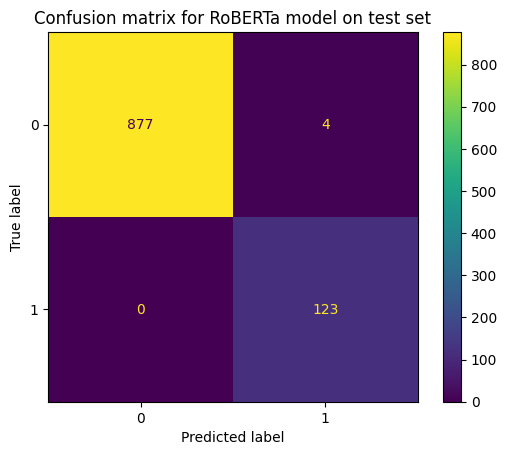

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay

bert_result = trainer.predict(tokenized_dataset['test'])
print("RoBERTa test accuracy = " + str(bert_result[2]['test_accuracy']))
print("RoBERTa test f1 score = " + str(bert_result[2]['test_f1']))
print("RoBERTa test balanced accuracy = " + str(bert_result[2]['test_balanced_accuracy']))
disp = ConfusionMatrixDisplay(confusion_matrix=bert_result[2]['test_confusion_matrix'])
disp.plot()
plt.title('Confusion matrix for RoBERTa model on test set')
plt.show()

## Albert Model

In [10]:
# This loads in the albert tokenizer
albert_tokenizer = AutoTokenizer.from_pretrained('albert-base-v2')

# This function tokenizes the text data with a given tokenizer
def albert_preprocess(examples):
    return albert_tokenizer(examples["sms"], truncation=True, padding = True)

# This tokenizes the dataset using the preprocess_function and the DistilBERT tokenizer
tokenized_dataset = dataset.map(albert_preprocess, batched=True)

print(tokenized_dataset)

Map: 100%|██████████| 669/669 [00:00<00:00, 20725.54 examples/s]

DatasetDict({
    train: Dataset({
        features: ['sms', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3901
    })
    test: Dataset({
        features: ['sms', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1004
    })
    valid: Dataset({
        features: ['sms', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 669
    })
})


In [ ]:
albert_model = AutoModelForSequenceClassification.from_pretrained('albert-base-v2')

# This creates a trainer using the BERT model, the training arguments, the tokenized dataset, the BERT tokenizer and the compute_metrics function
trainer = create_trainer(albert_model, tokenized_dataset, albert_tokenizer)

# This trains the model using the trainer
trainer.train()

# This evaluates the model using the trainer
trainer.evaluate()

100%|██████████| 63/63 [00:17<00:00,  3.57it/s]

Albert test accuracy = 0.8754980079681275
Albert test f1 score = 0.031007751937984496
Albert test balanced accuracy = 0.5058599337412216


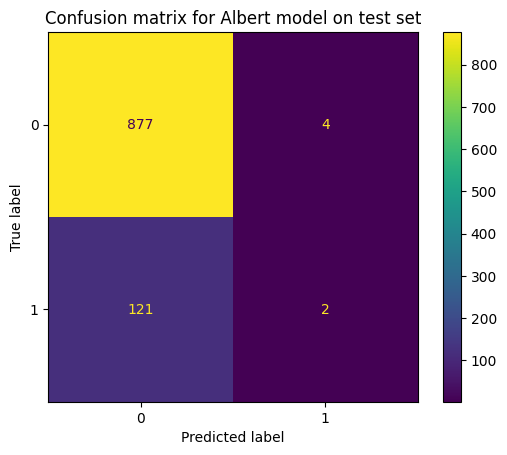

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay

bert_result = trainer.predict(tokenized_dataset['test'])
print("Albert test accuracy = " + str(bert_result[2]['test_accuracy']))
print("Albert test f1 score = " + str(bert_result[2]['test_f1']))
print("Albert test balanced accuracy = " + str(bert_result[2]['test_balanced_accuracy']))
disp = ConfusionMatrixDisplay(confusion_matrix=bert_result[2]['test_confusion_matrix'])
disp.plot()
plt.title('Confusion matrix for Albert model on test set')
plt.show()